# **Importamos el data set (Kaggle)**

In [27]:
#Dataset
import kagglehub
jangedoo_utkface_new_path = kagglehub.dataset_download('jangedoo/utkface-new')

print('Datos importados correctamente.')


Datos importados correctamente.


# **Importamos las librerias necesarias**

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# **Cargamos y ordenamos la data.**

In [29]:
images = []
ages = []


for i in os.listdir(os.path.join(jangedoo_utkface_new_path, 'crop_part1'))[0:8000]:
  split = i.split('_')
  ages.append(int(split[0]))
  images.append(Image.open(os.path.join(jangedoo_utkface_new_path, 'crop_part1', i)))


### **Organizamos la data en un DataFrame**

In [30]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')

df = pd.concat([images, ages], axis=1)
df

,Images,Ages
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,101
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10
...,...,...
7995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63
7996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63
7997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63
7998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63


### **Example:**

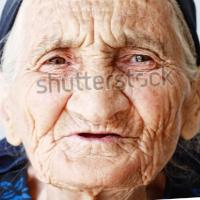

100


In [31]:
display(df['Images'][0])
print(df['Ages'][0])

# **Redimención y division de entrenamiento y prueba**

In [32]:
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 64  # Tamaño al que redimensionaremos todas las imágenes

# Convertimos PIL → NumPy, redimensionamos y normalizamos
X = np.array([
    np.array(ImageOps.fit(img, (IMG_SIZE, IMG_SIZE))).astype(np.float32) / 255.0
    for img in df['Images'] if isinstance(img, Image.Image)
])

# Convertimos etiquetas (0–4) → one-hot
y = np.array(df['Ages'])

# División en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Formas de los conjuntos:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


Formas de los conjuntos:
X_train: (6400, 64, 64, 3)
y_train: (6400,)


# **Definición del modelo**

In [33]:
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanado
model.add(Flatten())

# Capa densa intermedia
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Capa de salida para regresión
model.add(Dense(1, activation='linear'))  # Una salida con activación lineal para regresión

# Compilar
model.compile(loss='mean_squared_error',  # Usamos MSE para regresión
              optimizer='adam',
              metrics=['mean_absolute_error'])  # Usamos MAE como métrica para regresión

model.summary()


c:\Users\santi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

# **Primer entrenamiento del modelo**

In [13]:
# Primer entrenamiento

history1 = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    shuffle=True
)

model.save("modelo_utkface_age.h5")
print("Modelo guardado.")

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 421ms/step - loss: 825.7328 - mean_absolute_error: 22.8405 - val_loss: 674.2018 - val_mean_absolute_error: 20.6543
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - loss: 566.0007 - mean_absolute_error: 19.3835 - val_loss: 360.7730 - val_mean_absolute_error: 15.9189
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 34s 315ms/step - loss: 358.5747 - mean_absolute_error: 14.3156 - val_loss: 350.9156 - val_mean_absolute_error: 15.7058
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 43s 345ms/step - loss: 334.3254 - mean_absolute_error: 13.7688 - val_loss: 241.0665 - val_mean_absolute_error: 11.4455
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 323ms/step - loss: 280.3081 - mean_absolute_error: 12.3438 - val_loss: 234.8828 - val_mean_absolute_error: 11.7144
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 336ms/step - loss: 264.3412 - mean_absolute_error: 11.9355 - val_loss: 216.6460 - val_mean_absolute_error: 11.0576
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - los

Modelo guardado.


# **Seguir entrenando el modelo**

In [34]:
#Seguir entrenando el modelo
#Solo ejecutar si ya se ha entrenado antes!


# Cargar el modelo guardado
model = load_model("modelo_utkface_age.h5")

# Recompilar el modelo con las mismas configuraciones
model.compile(
    loss='mean_squared_error',
    optimizer=Adam(),
    metrics=['mean_absolute_error']
)


# Continuar el entrenamiento
history2 = model.fit(
    X_train, y_train,
    epochs=3,               # Epocas para agregar al entrenamiento
    batch_size=64,
    validation_split=0.2,
    shuffle=True
)

# Opcional: Guardar el modelo
model.save("modelo_utkface_age.h5")
print("Entrenamiento completado y modelo actualizado.")


Epoch 1/3
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 137.0112 - mean_absolute_error: 8.3934 - val_loss: 85.8747 - val_mean_absolute_error: 6.6204
Epoch 2/3
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 110.4196 - mean_absolute_error: 7.4728 - val_loss: 83.4565 - val_mean_absolute_error: 6.4050
Epoch 3/3
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 104.7936 - mean_absolute_error: 7.2141 - val_loss: 120.1098 - val_mean_absolute_error: 7.5595


Entrenamiento completado y modelo actualizado.


# **Cargar Modelo**

In [20]:
#Solo ejecutar si ya se ha entrenado antes!
model = load_model("modelo_utkface_age.h5")
model.evaluate(X_test, y_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 112.8519 - mean_absolute_error: 7.5083


[109.72352600097656, 7.46054744720459]

# **Graficar metricas del modelo**

In [35]:
import matplotlib.pyplot as plt

# Verifica qué historiales están disponibles
if 'history1' in globals() and 'history2' in globals():
    mae = history1.history['mean_absolute_error'] + history2.history['mean_absolute_error']
    val_mae = history1.history['val_mean_absolute_error'] + history2.history['val_mean_absolute_error']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
elif 'history1' in globals():
    mae = history1.history['mean_absolute_error']
    val_mae = history1.history['val_mean_absolute_error']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']
elif 'history' in globals():
    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
else:
    raise NameError("No se encontró ninguna variable de historial de entrenamiento.")

# Gráficas
plt.plot(mae, label='Train MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: No se encontró ninguna variable de historial de entrenamiento.

# **Predicciones**

In [23]:
race_labels = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Other'
}


# Predicción sobre las imágenes de prueba
predictions = model.predict(X_test)

# Convertir one-hot a índice de clase
predicted_classes = np.argmax(predictions, axis=1)

# Convertir también y_test (true labels) de one-hot a índices
true_classes = np.argmax(y_test, axis=1)

# Traducir a nombres de raza
predicted_races = [race_labels[i] for i in predicted_classes]
true_races = [race_labels[i] for i in true_classes]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

# **Resultados**

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import random

random_indices = random.sample(range(len(X_test)), 20)  # Elegimos 20 imágenes aleatorias

# Calcular error absoluto promedio para estas muestras
absolute_errors = [abs(true_ages[i] - predicted_ages[i]) for i in random_indices]
mae_subset = np.mean(absolute_errors)

# Configurar el gráfico (4 filas, 5 columnas)
fig, axes = plt.subplots(4, 5, figsize=(15, 9))
axes = axes.flatten()

for idx, i in enumerate(random_indices):
    ax = axes[idx]
    ax.imshow(X_test[i])
    ax.set_title(f"Pred: {predicted_ages[i]:.1f}\nReal: {true_ages[i]}")
    ax.axis('off')

# Mostrar error medio
plt.suptitle(f"Error absoluto medio (subset): {mae_subset:.2f}", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


NameError: name 'true_ages' is not defined